In [54]:
# Libraries used
import pandas as pd
import numpy as np
from scipy import stats
from sklearn.metrics import mean_squared_error
from collections import Counter
import warnings
from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.compose import make_column_transformer, ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder, StandardScaler, OneHotEncoder

from sklearn.linear_model import LinearRegression, Ridge, ElasticNet, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, VotingRegressor, StackingRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from sklearn.kernel_ridge import KernelRidge
import lightgbm as lgb

train_df = pd.read_csv("/home/druglord/Documents/ML/Competetion/house-prices-advanced-regression-techniques/train.csv")
test_df = pd.read_csv("/home/druglord/Documents/ML/Competetion/house-prices-advanced-regression-techniques/test.csv")
# train_df

In [ ]:
# Steps to follow
# 1. Remove outliers
#       1.1. Using Query
#       1.2. Use mean/median points
#       1.3. Use pyplots to look for outliers
#       1.4. Use zscore for outliers(4+ are outliers)
#       1.5. Delete associate id from train_df
#       1.6. Remove outliers
# 2. Handling missing values
# 3. Use median to replace value instead of mean
# 4. Remove Z score greater than 4, 5, 7, 8
# 5. Feature Engineering
#       5.1. One hot encoding
#       5.2. Binning => Group continuous data into bins
#       5.3. Polynomial Features
#       5.4. Feature Scaling
#       5.5. Log Transform
#       5.6. Target Encoding
#       5.7. Frequency encoding
#       5.8. Data bucketizing
#       5.9. Normalize
#       5.10. Feature Crossing
#       5.11. Principal Component Analysis
# 6. Neural Network gives better results?

In [2]:
# Removing outliers
# 1.1 Using Query
def analyze_outliers(arg1, arg2, quan_1, quan_3, arg1_val, arg2_val, arg1_val_max=None, arg2_val_max=None, andor = None):
    # Define your conditions
    if arg1_val_max is None and arg2_val_max is None:
        condition = f"{arg1} > {arg1_val} and {arg2} > {arg2_val}"
    elif arg1_val_max is None:
        condition = f"{arg1} > {arg1_val} and {arg2}.between({arg2_val}, {arg2_val_max})"
    elif arg2_val_max is None:
        condition = f"{arg1} > {arg1_val} and {arg1} <= {arg1_val_max} and {arg2} >= {arg2_val}"
    else:
        condition = f"{arg1} > {arg1_val}  and {arg1} <= {arg1_val_max} and {arg2}.between({arg2_val}, {arg2_val_max})"       
    
    flag = True
    outliers_q = train_df.query(condition)


# 1.2 Using mean/median value point
#       1.2.1 Normal Distribution
# Below => mean - 3 * (sigma)
# Above => mean + 3 * (sigma)
#       1.2.3 Skewed Distribution
# Below => q1 - 1.5 * iqr
# Above => q3 + 1.5 * iqr
    q1 = train_df[arg2].quantile(quan_1)
    q3 = train_df[arg2].quantile(quan_3)
    iqr = q3 - q1
    up = q3 + 1.5 * iqr
    low = q1 - 1.5 * iqr

    # Mean/median outlier
    outliers_m = train_df[(train_df[arg2] < low) | (train_df[arg2] > up)]

    # Zscore
    outliers_z_t = stats.zscore(train_df[arg2]).sort_values().tail(10)
    outliers_z = train_df.loc[train_df['Id'].isin(outliers_z_t.index.tolist())]

    # Query
    if flag:
        print("Outliers using query for", arg2, len(outliers_q))
        print(', '.join(map(str, outliers_q["Id"].tolist())))

    # Mean
        print("Outliers using mean/median", arg2, len(outliers_m["Id"].tolist()))
        print(', '.join(map(str, outliers_m["Id"].tolist())))

    # Train Raw
        print("Sale price zscore with train_df raw", arg2, len(outliers_z_t.index.tolist()))
        print(outliers_z_t)
        print(', '.join(map(str, [index + 1 for index in outliers_z_t.index.tolist()])))    

    # Scatter plots
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        # Suppress warnings when plotting KDE plots
        fig, axes = plt.subplots(1, 2, figsize=(16, 6))

        sns.scatterplot(x=arg1, y=arg2, data=train_df, label="train", ax=axes[0])
        sns.scatterplot(x=arg1, y=arg2, data=outliers_q, label="q", ax=axes[0])
        sns.scatterplot(x=arg1, y=arg2, data=outliers_m, label="m", ax=axes[0])
        sns.scatterplot(x=arg1, y=arg2, data=outliers_z, label="z", ax=axes[0])

        sns.kdeplot(x=arg1, y=arg2, data=train_df, color='blue', ax=axes[1])
        sns.kdeplot(x=arg1, y=arg2, data=outliers_q, color='orange', ax=axes[1], warn_singular=False)
        sns.kdeplot(x=arg1, y=arg2, data=outliers_m, color='green', ax=axes[1], warn_singular=False)
        sns.kdeplot(x=arg1, y=arg2, data=outliers_z, color='red', ax=axes[1], warn_singular=False)
        axes[0].set_title(f"Scatter Plot of {arg2} vs. SalePrice")
        axes[1].set_title(f"KDE Plot of {arg2} vs. SalePrice")
        

        plt.show()

Outliers using query for LotFrontage 0

Outliers using mean/median LotFrontage 2
935, 1299
Sale price zscore with train_df raw LotFrontage 10
1450   NaN
1451   NaN
1452   NaN
1453   NaN
1454   NaN
1455   NaN
1456   NaN
1457   NaN
1458   NaN
1459   NaN
Name: LotFrontage, dtype: float64
1451, 1452, 1453, 1454, 1455, 1456, 1457, 1458, 1459, 1460


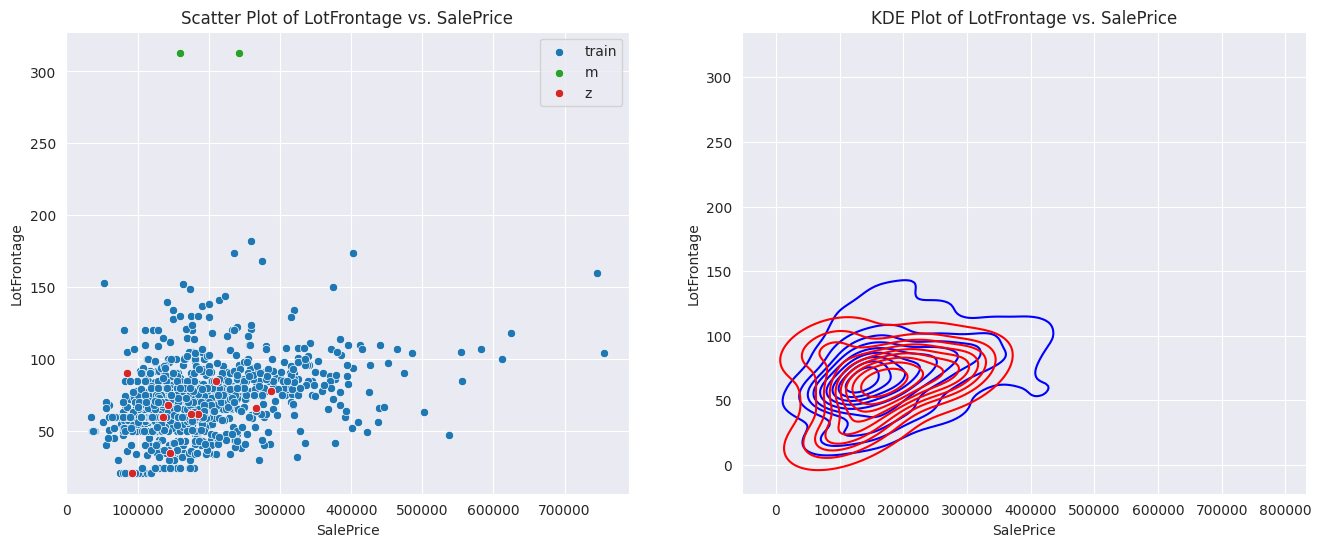

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,...,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,...,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,...,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,...,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,...,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


In [3]:
# Call the function with the desired arguments
analyze_outliers(arg1="SalePrice", arg2="LotFrontage", arg1_val=520000, arg2_val=160, arg1_val_max=None, arg2_val_max = None, quan_1=0.21, quan_3=0.95)
# print(train_df.dtypes[train_df.dtypes != 'object'].iloc[19:39])
# numeric_columns = train_df.select_dtypes(include=['int64', 'float64']).columns
train_df.describe()
# print(train_df.dtypes[train_df.dtypes != 'object'].iloc[29:])
# train_df.describe()

<Axes: xlabel='SalePrice', ylabel='LotArea'>

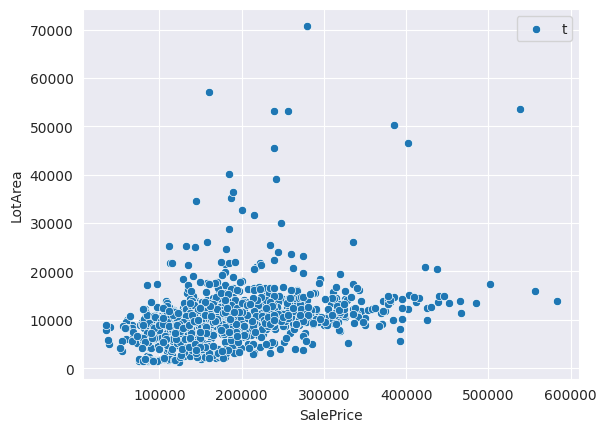

In [55]:
# Remove the outliers
ids = [692, 1170, 1183, 692, 1183, 935, 1299, 692, 1183, 707, 250, 336, 314, 692, 1183, 379, 692, 1183, 692, 1183, 186, 298, 692, 1170, 692, 1183, 692, 899, 1170, 1183, 1299, 441, 314, 692, 1183, 692, 899, 1170, 1183, 225, 692, 1183, 1299, 739, 692, 1183, 692, 1183, 598, 955, 692, 1183, 692, 1183, 636, 692, 1183, 955, 49, 810, 692, 1183, 636, 692, 1183, 582, 1062, 1191, 1299, 692, 899, 1170, 1183, 347, 1231]

counts = Counter(ids)
ll = []

for key, value in counts.items():
    # if value >= 2:
    ll.append(key)    

# for value in ll:
#     print(value , ids.count(value))

# Remove Id from train_df that are in new_df
new_df = train_df.loc[train_df['Id'].isin(ll)]
train_dff = train_df[~train_df['Id'].isin(new_df['Id'])]

sns.scatterplot(x="SalePrice", y="LotArea", data=train_dff, label="t")
# sns.scatterplot(x="SalePrice", y="LotArea", data=new_df, label="m")


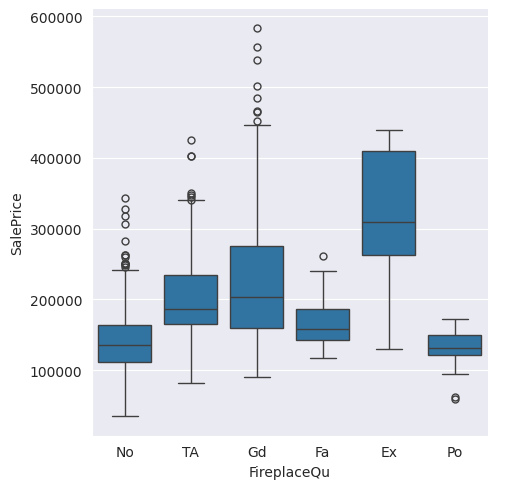

In [82]:
# 2. Handling missing values

# View the missing values
# Checking from this list we can fill values with our desired values
# print(train_df.dtypes[train_df.dtypes != 'object']


# Only printing object type data  for convenience
# Any value
# print(pd.DataFrame(train_dff.isnull().sum().sort_values(ascending=False)).head(20))

# Listing object
# print(pd.DataFrame(train_dff.select_dtypes(include=['object']).isnull().sum().sort_values(ascending=False)).head(20))

# Listing int and float
# print(pd.DataFrame(train_dff.select_dtypes(include=['int', 'float']).isnull().sum().sort_values(ascending=False)).head(10))



# 2.1 Check the value of that data that it contains

# print(train_dff["MiscFeature"].unique())
# print(train_dff.query('MiscFeature == "Shed"').count())
# print(train_dff.query('FireplaceQu == "Othr"').count())
# print(train_dff.query('FireplaceQu == "TenC"').count())



# print(train_dff["MasVnrType"].unique())
# print(train_dff.query('MasVnrType == "BrkFace"').count())
# print(train_dff.query('MasVnrType == "Stone"').count())
# print(train_dff.query('MasVnrType == "BrkCmn"').count())

# print(train_dff["FireplaceQu"].unique())
# print(train_dff.query('FireplaceQu == "TA"').count())
# print(train_dff.query('FireplaceQu == "Gd"').count())
# print(train_dff.query('FireplaceQu == "Fa"').count())
# print(train_dff.query('FireplaceQu == "Ex"').count())
# print(train_dff.query('FireplaceQu == "Po"').count())



# After looking at the catplot, we can decide which value to fill with
sns.catplot(x= "FireplaceQu", y = "SalePrice", data=train_dff, kind="box")

In [ ]:
# Storing the values that to be deleted
# Object type
# print(pd.DataFrame(train_dff.select_dtypes(include=['object']).isnull().sum().sort_values(ascending=False)).head(10))

# PoolQC        1429       #        ## 
# MiscFeature   1385       #        ## 
# Alley         1345      # N      ## N
# Fence         1156      # N      ## N
# MasVnrType     860      # N      ## N
# FireplaceQu    683      # N      ## N
# GarageType      77      # N      ## N
# GarageCond      77      # N      ## N
# GarageQual      77      # N      ## N
# GarageFinish    77      # N      ## -
# BsmtFinType2    38      # N      ## Unf
# BsmtExposure    38      # N      ## N
# BsmtFinType1    37      # Unf      ## Unf
# BsmtQual        37      # N      ## N
# BsmtCond        37      # N      ## N
# Electrical       1      # SBrk      ## SBrk



# Numerical type
# print(pd.DataFrame(train_dff.select_dtypes(include=['int', 'float']).isnull().sum().sort_values(ascending=False)).head(10))
# LotFrontage   253       # 0       ## 0
# GarageYrBlt    77       #        ## 
# MasVnrArea      8       # 0       ## 0

In [56]:
# Fill the Null/NaN values
train_dff["Alley"] = train_dff["Alley"].fillna("No")
test_df["Alley"] = test_df["Alley"].fillna("No")

train_dff["Fence"] = train_dff["Fence"].fillna("No")
test_df["Fence"] = test_df["Fence"].fillna("No")

train_dff["MasVnrType"] = train_dff["MasVnrType"].fillna("No")
test_df["MasVnrType"] = test_df["MasVnrType"].fillna("No")

train_dff["MasVnrArea"] = train_dff["MasVnrArea"].fillna(0)
test_df["MasVnrArea"] = test_df["MasVnrArea"].fillna(0)

train_dff["MasVnrArea"] = train_dff["MasVnrArea"].fillna(0)
test_df["MasVnrArea"] = test_df["MasVnrArea"].fillna(0)

train_dff["FireplaceQu"] = train_dff["FireplaceQu"].fillna("No")
test_df["FireplaceQu"] = test_df["FireplaceQu"].fillna("No")

train_dff["LotFrontage"] = train_dff["LotFrontage"].fillna(0)
test_df["LotFrontage"] = test_df["LotFrontage"].fillna(0)

train_dff["GarageCond"] = train_dff["GarageCond"].fillna("No")
test_df["GarageCond"] = test_df["GarageCond"].fillna("No")

train_dff["GarageType"] = train_dff["GarageType"].fillna("No")
test_df["GarageType"] = test_df["GarageType"].fillna("No")

train_dff["GarageFinish"] = train_dff["GarageFinish"].fillna("No")
test_df["GarageFinish"] = test_df["GarageFinish"].fillna("No")

train_dff["GarageQual"] = train_dff["GarageQual"].fillna("No")
test_df["GarageQual"] = test_df["GarageQual"].fillna("No")

train_dff["GarageFinish"] = train_dff["GarageFinish"].fillna("No")
test_df["GarageFinish"] = test_df["GarageFinish"].fillna("No")

train_dff["BsmtFinType2"] = train_dff["BsmtFinType2"].fillna("No")
test_df["BsmtFinType2"] = test_df["BsmtFinType2"].fillna("No")

train_dff["BsmtExposure"] = train_dff["BsmtExposure"].fillna("No")
test_df["BsmtExposure"] = test_df["BsmtExposure"].fillna("No")

train_dff["BsmtQual"] = train_dff["BsmtQual"].fillna("No")
test_df["BsmtQual"] = test_df["BsmtQual"].fillna("No")

train_dff["BsmtCond"] = train_dff["BsmtCond"].fillna("No")
test_df["BsmtCond"] = test_df["BsmtCond"].fillna("No")

train_dff["BsmtFinType1"] = train_dff["BsmtFinType1"].fillna("Unf")
test_df["BsmtFinType1"] = test_df["BsmtFinType1"].fillna("Unf")

train_dff["BsmtQual"] = train_dff["BsmtQual"].fillna("No")
test_df["BsmtQual"] = test_df["BsmtQual"].fillna("No")

train_dff["Electrical"] = train_dff["Electrical"].fillna("SBrkr")
test_df["Electrical"] = test_df["Electrical"].fillna("SBrkr")


# Check co-relation to get co-relation
# train_dff["GarageYrBlt"].corr(train_dff["YearBuilt"])
# sns.catplot(x= "Electrical", y = "SalePrice", data=train_dff, kind="box")

/tmp/ipykernel_74260/1352888015.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_dff["Alley"] = train_dff["Alley"].fillna("No")
/tmp/ipykernel_74260/1352888015.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_dff["Fence"] = train_dff["Fence"].fillna("No")
/tmp/ipykernel_74260/1352888015.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://panda

In [57]:
# 2.2 Drop the features with most of the missing values
train_dff = train_dff.drop(columns=['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'GarageYrBlt', 'GarageCond', 'BsmtFinType2'])
test_df = test_df.drop(columns=['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'GarageYrBlt', 'GarageCond', 'BsmtFinType2'])




In [58]:
# Feature Engineering
train_dff["houseage"] = train_dff["YrSold"] - train_dff["YearBuilt"]
test_df["houseage"] = test_df["YrSold"] - test_df["YearBuilt"]

train_dff["houseremodelage"] = train_dff["YrSold"] - train_dff["YearRemodAdd"]
test_df["houseremodelage"] = test_df["YrSold"] - test_df["YearRemodAdd"]

train_dff["totalsf"] = train_dff["1stFlrSF"] + train_dff["2ndFlrSF"] + train_dff["BsmtFinSF1"] + train_dff["BsmtFinSF2"]
test_df["totalsf"] = test_df["1stFlrSF"] + test_df["2ndFlrSF"] + test_df["BsmtFinSF1"] + test_df["BsmtFinSF2"]

train_dff["totalarea"] = train_dff["GrLivArea"] + train_dff["TotalBsmtSF"]
test_df["totalarea"] = test_df["GrLivArea"] + test_df["TotalBsmtSF"]

train_dff["totalbaths"] = train_dff["BsmtFullBath"] + train_dff["FullBath"] + 0.5 * train_dff["HalfBath"]
test_df["totalbaths"] = test_df["BsmtFullBath"] + test_df["FullBath"] + 0.5 * test_df["HalfBath"]

train_dff["totalporchdf"] = train_dff["OpenPorchSF"] + train_dff["3SsnPorch"] + train_dff["ScreenPorch"]
test_df["totalporchdf"] = test_df["OpenPorchSF"] + test_df["3SsnPorch"] + test_df["ScreenPorch"]


# # Drop unnecessary columns after feature engineering
train_dff = train_dff.drop(columns=['YrSold', 'YearBuilt', 'YearRemodAdd', '1stFlrSF', '2ndFlrSF', 'BsmtFinSF1', 'BsmtFinSF2', 'GrLivArea', 'TotalBsmtSF','BsmtFullBath', 'FullBath', 'BsmtHalfBath', 'HalfBath', 'OpenPorchSF', '3SsnPorch', 'EnclosedPorch', 'ScreenPorch','WoodDeckSF'])
test_df = test_df.drop(columns=['YrSold', 'YearBuilt', 'YearRemodAdd', '1stFlrSF', '2ndFlrSF', 'BsmtFinSF1', 'BsmtFinSF2', 'GrLivArea', 'TotalBsmtSF','BsmtFullBath', 'FullBath', 'BsmtHalfBath', 'HalfBath', 'OpenPorchSF', '3SsnPorch', 'EnclosedPorch', 'ScreenPorch','WoodDeckSF'])


In [59]:
# Generating a heatmap and drop value that has high correlation
# correlation_matrix = train_dff.corr(numeric_only=True)
# plt.figure(figsize = (16,12))
# sns.heatmap(correlation_matrix, annot = True, cmap = "coolwarm", fmt = ".2f")

# Drop any higher value from the heatmap(garage are/ garagecars)
train_dff = train_dff.drop(columns=["GarageArea"])
test_df = test_df.drop(columns=["GarageArea"])

# Now we can apply logarithm to values for better prediction
# sns.histplot(
#     train_dff,
#     x = train_dff["SalePrice"]
# )

train_dff["SalePrice"] = np.log1p(train_dff["SalePrice"])


In [60]:
# Build the pipeline
# print(train_dff.dtypes[train_dff.dtypes=="object"])
# print(train_dff.dtypes[train_dff.dtypes=="object"].index)

# objj = ['MSZoning', 'Street', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'Heating','HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'PavedDrive', 'SaleType', 'SaleCondition']

# printing the values of object type and its contents to sort out the values easily
# for i in objj:
#     print(f"{i} => ",train_dff[i].unique())


# Encoding the data
# Ordinal encoding will be used for data that has increasing values/objective values

ode_cols = ['LotShape', 'LandContour','Utilities','LandSlope',  'BsmtQual',  'BsmtFinType1',  'CentralAir',  'Functional', 'FireplaceQu', 'GarageFinish', 'GarageQual', 'PavedDrive', 'ExterCond', 'KitchenQual', 'BsmtExposure', 'HeatingQC','ExterQual', 'BsmtCond']
# 
ohe_cols = ['Street', 'LotConfig','Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'Exterior1st', 'Exterior2nd', 'MasVnrType','Foundation',  'Electrical',  'SaleType', 'MSZoning', 'SaleCondition', 'Heating', 'GarageType', 'RoofMatl']
# 
num_cols = train_dff.select_dtypes(include=["int", "float"]).columns
# # num_cols
num_cols = num_cols.drop("SalePrice")


In [61]:
num_pipeline = Pipeline(steps=[
    ("impute", SimpleImputer(strategy="mean")),
    ("scaler", StandardScaler())
])

ode_pipeline = Pipeline(steps=[
    ("impute", SimpleImputer(strategy="most_frequent")),
    ("ode", OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1))
])

ohe_pipeline = Pipeline(steps=[
    ("impute", SimpleImputer(strategy="most_frequent")),
    ("ohe", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

In [62]:
col_trans = ColumnTransformer(transformers=[
    ("num_p", num_pipeline, num_cols),
    ("ode_p", ode_pipeline, ode_cols),
    ("ohe_p", ohe_pipeline, ohe_cols),
    ],
    remainder="passthrough",
    n_jobs = -1)

In [63]:
# Pipeline building done
pipeline = Pipeline(steps=[
    ("preprocessing", col_trans)
])

In [64]:
# Data fitting
# Before dropping saleprice, always check if the value has been normalized
X = train_dff.drop("SalePrice", axis = 1)
y = train_dff["SalePrice"]


In [65]:
X_preprocessed = pipeline.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_preprocessed, y, test_size = .2, random_state = 20)

In [66]:
# Building Model for Linear Regression 
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

In [67]:
y_pred_lr = lr.predict(X_test)
mean_squared_error(y_test, y_pred_lr)

2442206010826295.5

In [ ]:
# For Random Forest Regressor
RFR = RandomForestRegressor(random_state=13)

param_grid_RFR = {"max_depth": [5, 10, 15],
            "n_estimators": [100, 250, 500],
            "min_samples_split": [ 3, 5, 10]
}
rfr_cv = GridSearchCV(RFR, param_grid_RFR, cv = 5, scoring = "neg_mean_squared_error", n_jobs = -1)
rfr_cv.fit(X_train, y_train)

In [26]:
# Check your score
print(np.sqrt(-1 * rfr_cv.best_score_))

# Check parameters that got the best score
# rfr_cv.best_params_

0.1412162758049419


{'max_depth': 15, 'min_samples_split': 3, 'n_estimators': 500}

In [22]:
# XGBoost Regressor
XGB = XGBRegressor(random_state = 13)
param_grid_XGB = {
    "learning_rate": [0.05, .1, .2],
    "n_estimators": [300],
    "max_depth": [3],
    "min_child_weight": [1, 2, 3],
    "gamma": [0, 0.1, 0.2],
    "subsample": [0.8, 0.9, 1],
    "colsample_bytree": [0.8, 0.9, 1]
}
xgb_cv = GridSearchCV(XGB, param_grid_XGB, cv = 3, scoring = "neg_mean_squared_error", n_jobs = -1)
xgb_cv.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, m...
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=13, ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.8, 0.9, 1],
                         'gamma': [0, 0.1, 0.2],
                         'learning_rate': [0.05, 0.1, 0.2], 'max_depth': [3],
                         'min_child_weight': [1, 2, 3], 'n_estimators': [300],
                         'subsample': [0.8, 0.9, 1]},
             scoring='neg_mean_squared_error')

In [150]:
print(np.sqrt(-1 * xgb_cv.best_score_))

0.12636691929034588


In [21]:
# Ridge regressor
ridge = Ridge()
param_grid_ridge = {
    "alpha": [0.05, .1, 1, 3, 5, 10],
    "solver": ["auto", "svd", "cholesky", "lsqr", "sparse_cg", "sag"], 
}
ridge_cv = GridSearchCV(ridge, param_grid_ridge, cv = 5, scoring = "neg_mean_squared_error", n_jobs = -1)
ridge_cv.fit(X_train, y_train)

/home/druglord/.local/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/druglord/.local/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/druglord/.local/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/druglord/.local/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/druglord/.local/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/druglord/.local/lib/python3.11/site-packages/sklearn/linear_mode

GridSearchCV(cv=5, estimator=Ridge(), n_jobs=-1,
             param_grid={'alpha': [0.05, 0.1, 1, 3, 5, 10],
                         'solver': ['auto', 'svd', 'cholesky', 'lsqr',
                                    'sparse_cg', 'sag']},
             scoring='neg_mean_squared_error')

In [27]:
print(np.sqrt(-1 * ridge_cv.best_score_))

0.13200816341266328


In [18]:
# Gradient Boosting Regression
GBR = GradientBoostingRegressor()
param_grid_GBR = {"max_depth": [12, 15, 20],
            "n_estimators": [200, 300, 1000],
            "min_samples_split": [ 10, 25, 50],
            "learning_rate": [.001, .01, .1],
            "max_features": [0.01, 0.1, 0.7]
}
GBR_cv = GridSearchCV(GBR, param_grid_GBR, cv = 5, scoring = "neg_mean_squared_error", n_jobs = -1)
GBR_cv.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=GradientBoostingRegressor(), n_jobs=-1,
             param_grid={'learning_rate': [0.001, 0.01, 0.1],
                         'max_depth': [12, 15, 20],
                         'max_features': [0.01, 0.1, 0.7],
                         'min_samples_split': [10, 25, 50],
                         'n_estimators': [200, 300, 1000]},
             scoring='neg_mean_squared_error')

In [19]:
np.sqrt(-1 * GBR_cv.best_score_)

0.1220777953869042

In [30]:
# LGVM Regressor
lgbm_regressor = lgb.LGBMRegressor()
param_grid_lgbm = {
    "boosting_type": ['gbdt', 'dart'],
    "num_leaves": [20, 30, 40],
    "learning_rate": [0.01, 0.05, 0.1],
    "n_estimators": [100, 200, 300]
}
lgbm_cv = GridSearchCV(lgbm_regressor, param_grid_lgbm, cv = 3, scoring = "neg_mean_squared_error", n_jobs = -1)
lgbm_cv.fit(X_train, y_train)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015426 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1734
[LightGBM] [Info] Number of data points in the train set: 764, number of used features: 106
[LightGBM] [Info] Start training from score 12.002492
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

GridSearchCV(cv=3, estimator=LGBMRegressor(), n_jobs=-1,
             param_grid={'boosting_type': ['gbdt', 'dart'],
                         'learning_rate': [0.01, 0.05, 0.1],
                         'n_estimators': [100, 200, 300],
                         'num_leaves': [20, 30, 40]},
             scoring='neg_mean_squared_error')

In [32]:
np.sqrt(-1 * lgbm_cv.best_score_)

0.1329081633594705

In [35]:
# Catboost Regressor
catboost = CatBoostRegressor(loss_function='RMSE', verbose=False)
param_grid_cat ={
    'iterations': [100, 500, 1000],
    'depth': [4, 6, 8, 10],
    'learning_rate': [0.01, 0.05, 0.1, 0.5]
}
cat_cv = GridSearchCV(catboost, param_grid_cat, cv=3, scoring='neg_mean_squared_error', n_jobs=-1)
cat_cv.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=<catboost.core.CatBoostRegressor object at 0x7f0ce484ddd0>,
             n_jobs=-1,
             param_grid={'depth': [4, 6, 8, 10], 'iterations': [100, 500, 1000],
                         'learning_rate': [0.01, 0.05, 0.1, 0.5]},
             scoring='neg_mean_squared_error')

In [36]:
np.sqrt(-1 * cat_cv.best_score_)

0.12172207134042247

In [47]:
# Voting Regressor
vr = VotingRegressor([
    ('gbr', GBR_cv.best_estimator_),
    ('xgb', xgb_cv.best_estimator_),
    ('ridge', ridge_cv.best_estimator_),
    ('cat', cat_cv.best_estimator_),
    ('lgb', lgbm_cv.best_estimator_),
    ('rfr', rfr_cv.best_estimator_)
],
    weights = [2, 3, 1, 3, 2, 1]
)

vr.fit(X_train, y_train)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000487 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1879
[LightGBM] [Info] Number of data points in the train set: 1147, number of used features: 113
[LightGBM] [Info] Start training from score 12.011144


VotingRegressor(estimators=[('gbr',
                             GradientBoostingRegressor(learning_rate=0.01,
                                                       max_depth=15,
                                                       max_features=0.1,
                                                       min_samples_split=50,
                                                       n_estimators=1000)),
                            ('xgb',
                             XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=0.8, device=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_...
                                          n_jobs=None, num_parallel_tree=None,
                                          random_state=13, ...)),
                            ('ridge', Ridge(alpha=10, solver='lsqr')),
                            ('cat',
                             <catboost.core.CatBoostRegressor object at 0x7f0cf04c7750>),
                            ('lgb',
                             LGBMRegressor(learning_rate=0.05, n_estimators=200,
                                           num_leaves=20)),
                            ('rfr',
                             RandomForestRegressor(max_depth=15,
                                                   min_samples_split=3,
                                                   n_estimators=500,
                                                   random_state=13))],
                weights=[2, 3, 1, 3, 2, 1])

In [48]:
y_pred_vr = vr.predict(X_test)
mean_squared_error(y_test, y_pred_vr, squared=False)

0.10635241752841725

In [49]:
# Using estimator
estimator = [
    ("gbr", GBR_cv.best_estimator_),
    ("xgb", xgb_cv.best_estimator_),
    ("cat", cat_cv.best_estimator_),
    ("lgb", lgbm_cv.best_estimator_),
    ("rfr", rfr_cv.best_estimator_),
]

In [50]:
# Stacking Regressor
stackreg = StackingRegressor(
    estimators = estimator,
    final_estimator=vr)
stackreg.fit(X_train, y_train)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000413 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1879
[LightGBM] [Info] Number of data points in the train set: 1147, number of used features: 113
[LightGBM] [Info] Start training from score 12.011144
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000405 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1790
[LightGBM] [Info] Number of data points in the train set: 917, number of used features: 108
[LightGBM] [Info] Start training from score 12.010699
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000379 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enou

StackingRegressor(estimators=[('gbr',
                               GradientBoostingRegressor(learning_rate=0.01,
                                                         max_depth=15,
                                                         max_features=0.1,
                                                         min_samples_split=50,
                                                         n_estimators=1000)),
                              ('xgb',
                               XGBRegressor(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=0.8, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eva...
                                                                            n_jobs=None,
                                                                            num_parallel_tree=None,
                                                                            random_state=13, ...)),
                                                              ('ridge',
                                                               Ridge(alpha=10,
                                                                     solver='lsqr')),
                                                              ('cat',
                                                               <catboost.core.CatBoostRegressor object at 0x7f0cf04c7750>),
                                                              ('lgb',
                                                               LGBMRegressor(learning_rate=0.05,
                                                                             n_estimators=200,
                                                                             num_leaves=20)),
                                                              ('rfr',
                                                               RandomForestRegressor(max_depth=15,
                                                                                     min_samples_split=3,
                                                                                     n_estimators=500,
                                                                                     random_state=13))],
                                                  weights=[2, 3, 1, 3, 2, 1]))

In [43]:
y_pred_stack = stackreg.predict(X_test)

In [53]:
mean_squared_error(y_test, y_pred_stack, squared=False)
df_test_preprocess = pipeline.transform(test_df)


y_stacking = np.exp(stackreg.predict(df_test_preprocess))
df_y_stacking_out = test_df[['Id']]
df_y_stacking_out['SalePrice'] = y_stacking

df_y_stacking_out.to_csv('submission.csv', index=False)



KeyError: "None of [Index(['Id'], dtype='object')] are in the [columns]"

In [ ]:
mean_squared_error(y_test, y_pred_lr) Linear Regressor = 2.6946185128262856e+16
print(np.sqrt(-1 * rfr_cv.best_score_)) RandomForestRegressor = 0.1412162758049419
print(np.sqrt(-1 * xgb_cv.best_score_)) XGBRegressor = 0.12636691929034588
print(np.sqrt(-1 * ridge_cv.best_score_)) Ridge = 0.13200816341266328
np.sqrt(-1 * GBR_cv.best_score_) GradientBoostingRegressor = 0.1220777953869042
np.sqrt(-1 * lgbm_cv.best_score_) LGBMRegressor = 0.1329081633594705
np.sqrt(-1 * cat_cv.best_score_) CatBoostRegressor = 0.12172207134042247
np.sqrt(-1 * cat_cv.best_score_) VotingRegressor = 0.10421101982115512
mean_squared_error(y_test, y_pred_stack, squared=False) StackingRegressor =

In [251]:
#  Outliers using query for MSSubClass 3
# 692, 1170, 1183

# Outliers using query for LotFrontage 2
# 692, 1183
# Outliers using mean/median LotFrontage 2
# 935, 1299


# Outliers using query for LotArea 2
# 692, 1183, 707, 250, 336, 314


# Outliers using query for OverallQual 2
# 692, 1183

# Outliers using query for OverallCond 1
# 379, 692, 1183

# Outliers using query for YearBuilt 2
# 692, 1183, 186

# Outliers using mean/median MasVnrArea 3
# 298, 692, 1170, 
# Outliers using query for MasVnrArea 2
# 692, 1183

# Outliers using query for BsmtFinSF1 4
# 692, 899, 1170, 1183
# Outliers using mean/median BsmtFinSF1 1
# 1299
# 
# Outliers using query for BsmtFinSF2 1
# 441, 314
# Outliers using query for BsmtFinSF2 1
# 692, 1183


# Outliers using query for BsmtUnfSF 4
# 692, 899, 1170, 1183, 225

# Outliers using query for TotalBsmtSF 2
# 692, 1183
# Outliers using mean/median TotalBsmtSF 1
# 1299

# Outliers using mean/median BsmtFullBath 1
# 739
# Outliers using query for BsmtFullBath 2
# 692, 1183

# Outliers using query for BsmtHalfBath 2
# 692, 1183
# Outliers using query for BsmtHalfBath 2
# 598, 955

# Outliers using query for FullBath 2
# 692, 1183


# Outliers using query for HalfBath 2
# 692, 1183

# Outliers using query for BedroomAbvGr 2
# 692, 1183
# Outliers using mean/median BedroomAbvGr 1
# 636

# Outliers using query for KitchenAbvGr 2
# 692, 1183, 955, 49, 810
# 
# Outliers using query for TotRmsAbvGrd 2
# 692, 1183
# Outliers using mean/median TotRmsAbvGrd 1
# 636
# 
# Outliers using query for GarageArea 2
# 692, 1183
# Outliers using mean/median GarageArea 4
# 582, 1062, 1191, 1299

# Outliers using query for YrSold 4
# 692, 899, 1170, 1183
# 
# Outliers using query for MiscVal 2
# 347, 1231

array([nan, 'Grvl', 'Pave'], dtype=object)